In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 63.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-06-18 05:10:29--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2021-06-18 05:10:30 (43.5 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [ ]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 16)             64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 32)             1568      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
___________________________________________________________

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 51ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0105
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 11/100
4/4 [==========

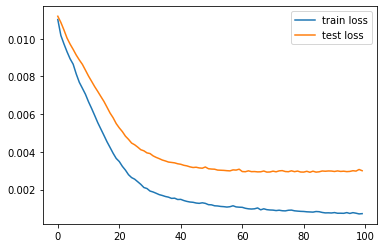

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

In [ ]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

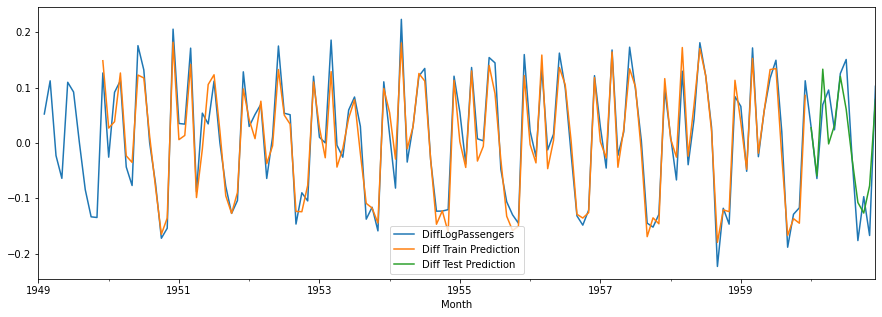

In [ ]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(15, 5));

In [ ]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

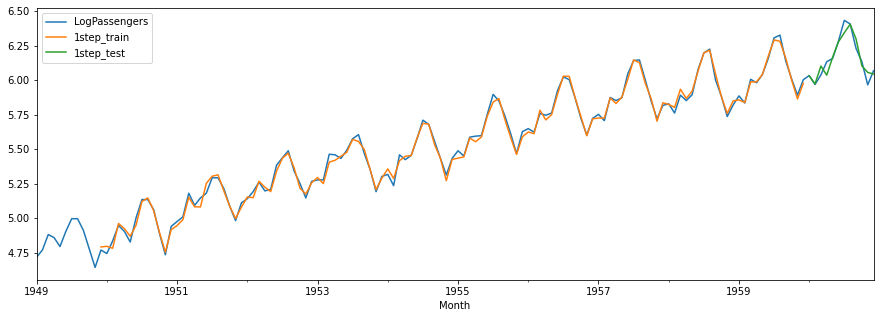

In [ ]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

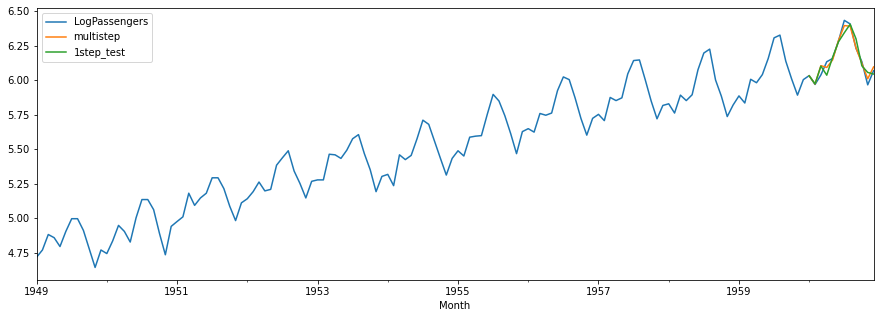

In [ ]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [ ]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=200,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 [==============================] - 1s 88ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 4/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 5/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 8/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 9/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 10/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 11/200
4/4 [========

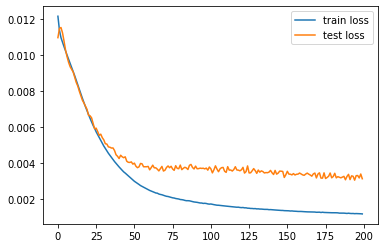

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [ ]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

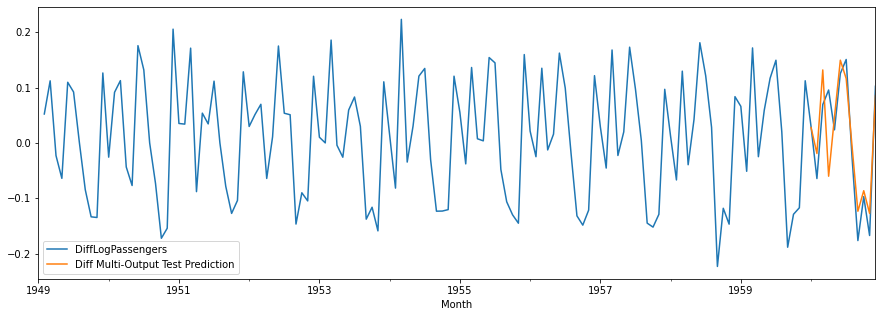

In [ ]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15, 5));

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

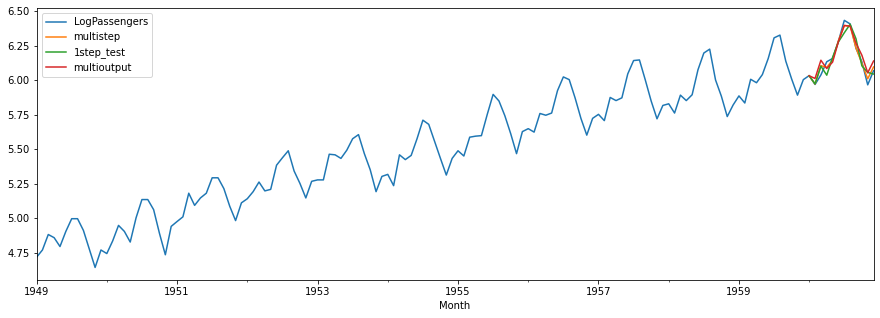

In [ ]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.0036427361792870476
multi-output MAPE: 0.0071554218103232455


In [ ]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?